# NCDC retrieve CH data

## Reset and initialization

In [132]:
%reset -sf
from urllib.request import urlopen
import pandas as pd
#from pandas import read_csv, read_fwf, to_numeric, to_datetime, set_option
pd.set_option("display.max.columns", None)

url_type = 'ftp://anonymous@' 
url = 'ftp.ncei.noaa.gov'
daily = '/pub/data/ghcn/daily/'
yzip_url = url_type + url + daily + 'by_year/'
szip_url = url_type + url + daily + 'by_station/'

## List available years

## A) Display contents of readme-by_year.txt

## B) Section III of the GHCN-Daily readme.txt

## C) Display contents of readme-by_station.txt

## List of country codes (FIPS) and names

In [133]:
#CODE          1-2    Character
#NAME          4-64   Character
colspecs = [(0,2),(3,None)]
cols = ['CODE','NAME']
dtype = {'col1': str, 'col2': str}
countries = pd.read_fwf(url_type+url+daily+'ghcnd-countries.txt', colspecs=colspecs, names=cols ,dtype=dtype)
print(countries)

    CODE                         NAME
0     AC          Antigua and Barbuda
1     AE         United Arab Emirates
2     AF                  Afghanistan
3     AG                      Algeria
4     AJ                   Azerbaijan
..   ...                          ...
214   WI               Western Sahara
215   WQ  Wake Island [United States]
216   WZ                    Swaziland
217   ZA                       Zambia
218   ZI                     Zimbabwe

[219 rows x 2 columns]


## File listing the periods of record for each station and element

In [134]:
#ID            1-11   Character
#LATITUDE     13-20   Real
#LONGITUDE    22-30   Real
#ELEMENT      32-35   Character
#FIRSTYEAR    37-40   Integer
#LASTYEAR     42-45   Integer
colspecs = [(0,11),(12,20),(21,30),(31,35),(36,40),(41,None)]
cols = ['ID','LATITUDE','LONGITUDE','ELEMENT','FIRSTYEAR','LASTYEAR']
dtype = {'col1': str, 'col2': float, 'col2': float, 'col2': str, 'col2': int, 'col2': int}
inventory = pd.read_fwf(url_type+url+daily+'ghcnd-inventory.txt', colspecs=colspecs, names=cols ,dtype=dtype)
print(inventory)

                 ID  LATITUDE  LONGITUDE ELEMENT  FIRSTYEAR  LASTYEAR
0       ACW00011604   17.1167   -61.7833    TMAX       1949      1949
1       ACW00011604   17.1167   -61.7833    TMIN       1949      1949
2       ACW00011604   17.1167   -61.7833    PRCP       1949      1949
3       ACW00011604   17.1167   -61.7833    SNOW       1949      1949
4       ACW00011604   17.1167   -61.7833    SNWD       1949      1949
...             ...       ...        ...     ...        ...       ...
733978  ZI000067983  -20.2000    32.6160    PRCP       1951      2020
733979  ZI000067983  -20.2000    32.6160    TAVG       1962      2020
733980  ZI000067991  -22.2170    30.0000    TMAX       1951      1990
733981  ZI000067991  -22.2170    30.0000    TMIN       1951      1990
733982  ZI000067991  -22.2170    30.0000    PRCP       1951      1990

[733983 rows x 6 columns]


## List of U.S. state and Canadian Province codes 

## List of stations and their metadata (e.g., coordinates): WMO_ID has decimals?

In [135]:
#ID            1-11   Character
#LATITUDE     13-20   Real
#LONGITUDE    22-30   Real
#ELEVATION    32-37   Real
#STATE        39-40   Character
#NAME         42-71   Character
#GSN FLAG     73-75   Character
#HCN/CRN FLAG 77-79   Character
#WMO ID       81-85   Character
colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,None)]
cols = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN FLAG','HCN/CRN FLAG','WMO ID']
dtype = {'col1': str, 'col2': float, 'col3': float, 'col4': float, 
         'col5': str, 'col6': str, 'col7': str, 'col8': str, 'col9': str}
stations = pd.read_fwf(url_type+url+daily+'ghcnd-stations.txt', header=None, colspecs=colspecs, names=cols ,dtype=dtype)
#
# Issue is NaN values can't coexist with integers in a numeric series. Since NaN is a float, Pandas forces upcasting. 
stations['WMO ID'] = pd.to_numeric(stations['WMO ID'], errors='coerce').fillna(-1).astype(int)
print(stations)
print(stations.info())

                 ID  LATITUDE  LONGITUDE  ELEVATION STATE  \
0       ACW00011604   17.1167   -61.7833       10.1   NaN   
1       ACW00011647   17.1333   -61.7833       19.2   NaN   
2       AE000041196   25.3330    55.5170       34.0   NaN   
3       AEM00041194   25.2550    55.3640       10.4   NaN   
4       AEM00041217   24.4330    54.6510       26.8   NaN   
...             ...       ...        ...        ...   ...   
123341  ZI000067969  -21.0500    29.3670      861.0   NaN   
123342  ZI000067975  -20.0670    30.8670     1095.0   NaN   
123343  ZI000067977  -21.0170    31.5830      430.0   NaN   
123344  ZI000067983  -20.2000    32.6160     1132.0   NaN   
123345  ZI000067991  -22.2170    30.0000      457.0   NaN   

                         NAME GSN FLAG HCN/CRN FLAG  WMO ID  
0       ST JOHNS COOLIDGE FLD      NaN          NaN      -1  
1                    ST JOHNS      NaN          NaN      -1  
2         SHARJAH INTER. AIRP      GSN          NaN   41196  
3                  

## First available year is 1750

## ... Current year is 2023

## Extract country ID for Switzerland and apply it to see all stations there

In [136]:
#code = countries[countries['NAME'].str.lower().isin(['italy'])]['CODE'].iloc[0]
code = countries[countries['NAME'].str.lower()=='switzerland']['CODE'].iloc[0]
print(f'Country ID for Switzerland is {code}.')

Country ID for Switzerland is SZ.


### For instance, the weather station of Bologna:

In [137]:
ws = stations[(stations['ID'].str[0:2]==code)&(stations['NAME'].str.startswith('BAS'))]
bid = ws['ID'].iloc[0]
#bws = stations[(stations['ID'].str[0:2]==code)&(stations['NAME'].str.startswith('BOL'))]
#bid = bws['ID'].iloc[0]
#ws = bws['NAME'].iloc[0]
print(ws)

                ID  LATITUDE  LONGITUDE  ELEVATION STATE             NAME  \
52118  SZ000001940   47.5331     7.5831      316.0   NaN  BASEL BINNINGEN   

      GSN FLAG HCN/CRN FLAG  WMO ID  
52118      NaN          NaN    6601  


### The inventory of Basel/Binningen weather stations

In [138]:
df = inventory.merge(ws, on=['ID'])
print(df)
print(bid)


            ID  LATITUDE_x  LONGITUDE_x ELEMENT  FIRSTYEAR  LASTYEAR  \
0  SZ000001940     47.5331       7.5831    TMAX       1901      2023   
1  SZ000001940     47.5331       7.5831    TMIN       1901      2023   
2  SZ000001940     47.5331       7.5831    PRCP       1901      2023   
3  SZ000001940     47.5331       7.5831    SNWD       1931      2023   
4  SZ000001940     47.5331       7.5831    TAVG       1990      2023   

   LATITUDE_y  LONGITUDE_y  ELEVATION STATE             NAME GSN FLAG  \
0     47.5331       7.5831      316.0   NaN  BASEL BINNINGEN      NaN   
1     47.5331       7.5831      316.0   NaN  BASEL BINNINGEN      NaN   
2     47.5331       7.5831      316.0   NaN  BASEL BINNINGEN      NaN   
3     47.5331       7.5831      316.0   NaN  BASEL BINNINGEN      NaN   
4     47.5331       7.5831      316.0   NaN  BASEL BINNINGEN      NaN   

  HCN/CRN FLAG  WMO ID  
0          NaN    6601  
1          NaN    6601  
2          NaN    6601  
3          NaN    6601  
4  

In [140]:
#ID = 11 character station identification code
#YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)
#ELEMENT = 4 character indicator of element type 
#DATA VALUE = 5 character data value for ELEMENT 
#M-FLAG = 1 character Measurement Flag 
#Q-FLAG = 1 character Quality Flag 
#S-FLAG = 1 character Source Flag 
#OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 =7:00 am); if no ob time information 
#is available, the field is left empty
cols = ['ID','YEAR/MONTH/DAY','ELEMENT','DATA VALUE','M-FLAG','Q-FLAG','S-FLAG','OBS-TIME']
bb = pd.read_csv(szip_url+bid+'.csv.gz', header=None, compression='gzip', names=cols).drop(labels='ID', axis=1)
bb['YEAR/MONTH/DAY'] = pd.to_datetime(bb['YEAR/MONTH/DAY'], format='%Y%m%d')
bb.set_index('YEAR/MONTH/DAY')
print(bb)

       YEAR/MONTH/DAY ELEMENT  DATA VALUE M-FLAG Q-FLAG S-FLAG  OBS-TIME
0          1901-01-01    TMAX          75    NaN    NaN      E       NaN
1          1901-01-02    TMAX           0    NaN    NaN      E       NaN
2          1901-01-03    TMAX         -30    NaN    NaN      E       NaN
3          1901-01-04    TMAX         -45    NaN    NaN      E       NaN
4          1901-01-05    TMAX         -55    NaN    NaN      E       NaN
...               ...     ...         ...    ...    ...    ...       ...
175795     2023-02-12    TAVG          22      H    NaN      S       NaN
175796     2023-02-13    TAVG          53      H    NaN      S       NaN
175797     2023-02-14    TAVG          29      H    NaN      S       NaN
175798     2023-02-15    TAVG          36      H    NaN      S       NaN
175799     2023-02-16    TAVG          63      H    NaN      S       NaN

[175800 rows x 7 columns]


/tmp/ipykernel_35005/3187834348.py:11: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  bb = pd.read_csv(szip_url+bid+'.csv.gz', header=None, compression='gzip', names=cols).drop(labels='ID', axis=1)


### How many unique elements are observed?

In [141]:
ue = bb['ELEMENT'].unique().tolist()
print(ue)
#pd.Series({c: bo[c].unique() for c in bo})
print('... as we already know from the evaluation of the inventory.')

['TMAX', 'TMIN', 'PRCP', 'SNWD', 'TAVG']
... as we already know from the evaluation of the inventory.


### Transpose observations from rows to columns

In [151]:
dfr = bb
def extractObservation(dfr, obs_col, data_col, data_list, obs):
    df = dfr.loc[dfr[obs_col]==obs,data_list]
    df.rename({data_col: obs}, axis=1, inplace=True)
    return df
    
df_list = [extractObservation(dfr, 'ELEMENT', 'DATA VALUE', ['YEAR/MONTH/DAY','DATA VALUE'], e) for e in ue]

df = pd.merge(df_list[0], df_list[1], on='YEAR/MONTH/DAY', how='outer')
for i in range(2, len(df_list)):
    df = pd.merge(df, df_list[i], on='YEAR/MONTH/DAY', how='outer')
    
print(df)

      YEAR/MONTH/DAY  TMAX   TMIN  PRCP  SNWD   TAVG
0         1901-01-01  75.0  -10.0  22.0   NaN    NaN
1         1901-01-02   0.0  -40.0  25.0   NaN    NaN
2         1901-01-03 -30.0  -70.0   0.0   NaN    NaN
3         1901-01-04 -45.0 -115.0   0.0   NaN    NaN
4         1901-01-05 -55.0 -135.0   0.0   NaN    NaN
...              ...   ...    ...   ...   ...    ...
44598     2016-05-02   NaN    NaN   NaN   NaN  114.0
44599     2016-06-01   NaN    NaN   NaN   NaN  163.0
44600     2016-06-02   NaN    NaN   NaN   NaN  158.0
44601     2016-07-01   NaN    NaN   NaN   NaN  212.0
44602     2016-07-02   NaN    NaN   NaN   NaN  169.0

[44603 rows x 6 columns]


array([[<AxesSubplot:xlabel='TMAX', ylabel='TMAX'>,
        <AxesSubplot:xlabel='TMIN', ylabel='TMAX'>,
        <AxesSubplot:xlabel='PRCP', ylabel='TMAX'>,
        <AxesSubplot:xlabel='SNWD', ylabel='TMAX'>,
        <AxesSubplot:xlabel='TAVG', ylabel='TMAX'>],
       [<AxesSubplot:xlabel='TMAX', ylabel='TMIN'>,
        <AxesSubplot:xlabel='TMIN', ylabel='TMIN'>,
        <AxesSubplot:xlabel='PRCP', ylabel='TMIN'>,
        <AxesSubplot:xlabel='SNWD', ylabel='TMIN'>,
        <AxesSubplot:xlabel='TAVG', ylabel='TMIN'>],
       [<AxesSubplot:xlabel='TMAX', ylabel='PRCP'>,
        <AxesSubplot:xlabel='TMIN', ylabel='PRCP'>,
        <AxesSubplot:xlabel='PRCP', ylabel='PRCP'>,
        <AxesSubplot:xlabel='SNWD', ylabel='PRCP'>,
        <AxesSubplot:xlabel='TAVG', ylabel='PRCP'>],
       [<AxesSubplot:xlabel='TMAX', ylabel='SNWD'>,
        <AxesSubplot:xlabel='TMIN', ylabel='SNWD'>,
        <AxesSubplot:xlabel='PRCP', ylabel='SNWD'>,
        <AxesSubplot:xlabel='SNWD', ylabel='SNWD'>,
        <

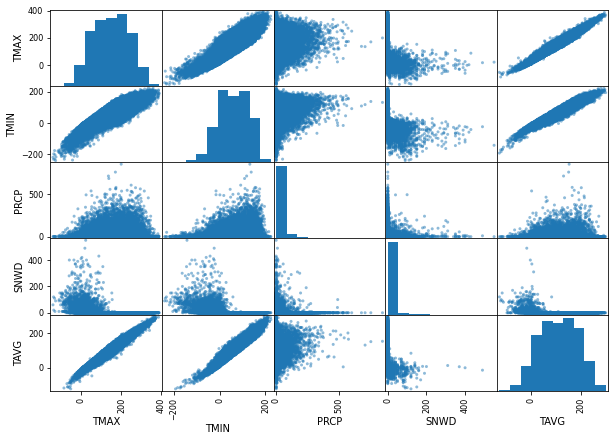

In [152]:
pd.plotting.scatter_matrix(df, figsize=[10,7])

<AxesSubplot:>

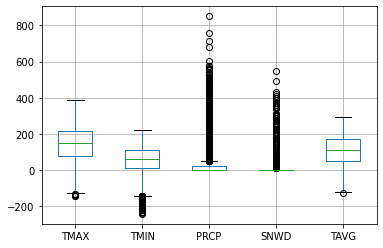

In [153]:
pd.plotting.boxplot(df)